# Predicting LSST Self-follow-up

In this notebook I assess the efficiency of our algorithm in predicting whether LSST will perform self-follow-up on an object.

You can find the code for the creation of Figures 2 and 6.

In [34]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets

import difi
import thor

import variant_orbits
import scheduling
import detection_probability
import magnitudes

In [5]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

# Assess Algorithm Accuracy

### Get data

In [6]:
detection_window = 15
min_nights = 3

In [7]:
def get_results(obj_type="neo", night_range=range(363)):
    real_det_nights = pd.read_hdf(f"findable_obs_{obj_type}.h5")
    probs = [None for _ in night_range]
    hexs = [None for _ in night_range]
    det_window = [None for _ in night_range]
    det_ever = [None for _ in night_range]
    for i, night in enumerate(night_range):
        night_probs, unique_objs = np.load(f"latest_runs/{obj_type}_night{night}_probs.npy", allow_pickle=True)

        reduced = real_det_nights.loc[list(set(real_det_nights.index).intersection(set(unique_objs)))]

        already_ids = reduced[reduced < night].index.values
        window_ids = reduced[(reduced >= night) &
                             (reduced < night + detection_window)].index.values
        ever_ids = reduced[(reduced >= night + detection_window)].index.values

        # hack for neos before I fixed it
        if obj_type == "neo":
            yet_to_be_found = ~np.isin(unique_objs, already_ids)
            unique_objs = unique_objs[yet_to_be_found]
            night_probs = night_probs[yet_to_be_found]

        probs[i] = night_probs
        hexs[i] = unique_objs
        det_window[i] = np.isin(unique_objs, window_ids)
        det_ever[i] = np.isin(unique_objs, ever_ids)
    probs = np.concatenate(probs)
    hexs = np.concatenate(hexs)
    det_window = np.concatenate(det_window)
    det_ever = np.concatenate(det_ever)
    
    return pd.DataFrame(data={"prob": probs, "hex_id": hexs, "det_window": det_window, "det_ever": det_ever},
                        columns=["prob", "hex_id", "det_window", "det_ever"])

In [35]:
neo_results = get_results(obj_type="neo")

In [37]:
%%time
mba_results = get_results(obj_type="mba")

CPU times: user 4min 55s, sys: 36.2 s, total: 5min 32s
Wall time: 5min 37s


In [18]:
obs_dfs = [pd.read_hdf(f"../neocp/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
all_obs = pd.concat(obs_dfs)

In [19]:
n_unique = np.array([len(all_obs[all_obs["night"] == n]["ObjID"].unique()) for n in range(377)])

In [28]:
okay = n_unique != 0

### Calculate stats and plot

In [38]:
def assess_algorithm_results(results,
                             threshold=0.5, obj_type="neo",
                             log=None, bin_count=50, dedup=False, plot=True, save_plot=False):
    if dedup:
        results = results.drop_duplicates(subset="hex_id", keep="first")
    if log is None:
        log = True if obj_type == "mba" else False
    correct_detectable = len(results["prob"][(results["prob"] >= threshold) & results["det_window"]])
    correct_undetectable = len(results["prob"][(results["prob"] < threshold) & ~results["det_window"]])
    incorrect_detectable = len(results["prob"][(results["prob"] >= threshold) & ~results["det_window"]])
    incorrect_undetectable = len(results["prob"][(results["prob"] < threshold) & results["det_window"]])

    c_u_eventually = len(results["prob"][(results["prob"] < threshold) & ~results["det_window"] & results["det_ever"]])
    i_d_eventually = len(results["prob"][(results["prob"] >= threshold) & ~results["det_window"] & results["det_ever"]])

    print(f'Of the {len(results["prob"])} objects, we classified')
    print(f"  {correct_detectable + correct_undetectable} correctly")
    print(f"    {correct_detectable} were detectable")
    print(f"    {correct_undetectable} were undetectable")
    print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
    print(f"    {incorrect_detectable} were detectable")
    print(f"    {incorrect_undetectable} were undetectable")
    print(f'Overall success rate: {100 * (correct_detectable + correct_undetectable) / len(results["prob"]):1.2f}%')

    if not plot:
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    fig.suptitle(f"{obj_type.upper()}s", fontsize=1.1*fs)

    bins = np.linspace(0, 1, bin_count)
    
    axes[0].hist(results["prob"][results["det_window"]], label="Detected", bins=bins, log=log, edgecolor="none", rasterized=True)
    axes[0].hist(results["prob"][~results["det_window"]], alpha=0.6, label="Not detected", bins=bins, log=log, edgecolor="none", rasterized=True)
    axes[0].axvline(threshold, color="tab:red", linestyle="--", lw=3)

    axes[0].set_xlabel("Estimated probability of detection")
    axes[0].set_ylabel("Number of objects")
    axes[0].legend(fontsize=0.7*fs)

#     axes[1].set_title(f"{obj_type.upper()}s", fontsize=1.1*fs)

    axes[1].axvline(0.5, color="white", linestyle="dotted")
    axes[1].axhline(0.5, color="white", linestyle="dotted")

    axes[1].annotate("Detectable", xy=(0.25, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)
    axes[1].annotate("Undetectable", xy=(0.75, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)

    axes[1].annotate("Undetectable", xy=(-0.02, 0.25), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)
    axes[1].annotate("Detectable", xy=(-0.02, 0.75), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)

    axes[1].annotate(incorrect_undetectable, xy=(0.25, 0.25), ha="center", va="center", fontsize=1.5*fs)
    axes[1].annotate("Excess NEOCP", xy=(0.25, 0.15), ha="center", va="center", fontsize=0.6*fs)
    axes[1].annotate(correct_undetectable, xy=(0.75, 0.25), ha="center", va="center", fontsize=1.5*fs)
    axes[1].annotate(f"{c_u_eventually} found after window", xy=(0.98, 0.02), ha="right", va="bottom", fontsize=0.4*fs)
    axes[1].annotate(incorrect_detectable, xy=(0.75, 0.75), ha="center", va="center", fontsize=1.5*fs)
    axes[1].annotate("Lost objects", xy=(0.75, 0.65), ha="center", va="center", fontsize=0.6*fs)
    axes[1].annotate(f"{i_d_eventually} found after window", xy=(0.98, 0.98), ha="right", va="top", fontsize=0.4*fs)
    axes[1].annotate(correct_detectable, xy=(0.25, 0.75), ha="center", va="center", fontsize=1.5*fs)

    axes[1].axvspan(0, 0.5, 0, 0.5, color=plt.cm.Reds(incorrect_undetectable / len(results["prob"])))
    axes[1].axvspan(0.5, 1, 0, 0.5, color=plt.cm.Greens(correct_undetectable / len(results["prob"])))
    axes[1].axvspan(0, 0.5, 0.5, 1, color=plt.cm.Greens(correct_detectable / len(results["prob"])))
    axes[1].axvspan(0.5, 1, 0.5, 1, color=plt.cm.Reds(incorrect_detectable / len(results["prob"])))

    axes[1].set_xlabel("\nTruth")
    axes[1].set_ylabel("Prediction\n")

    axes[1].set_xticks([])
    axes[1].set_yticks([])

    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)

    if save_plot:
        plt.savefig(f"../paper/figures/contingency_{obj_type}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

In [41]:
def what_if_threshold(threshold, neo_results, mba_results, num_nights, dedup=False):
    
    if dedup:
        neo_results = neo_results.drop_duplicates(subset="hex_id", keep="first")
        mba_results = mba_results.drop_duplicates(subset="hex_id", keep="first")
    
    traffic = len(neo_results["prob"][neo_results["prob"] <= threshold])\
        + len(mba_results["prob"][mba_results["prob"] <= threshold])
    avg_traffic = traffic / num_nights
    purity = len(neo_results["prob"][neo_results["prob"] <= threshold]) / traffic 
    
    
    
    neos_lost = len(neo_results["prob"][(neo_results["prob"] > threshold)
                                        & ~neo_results["det_window"]
                                        & ~neo_results["det_ever"]])
    
    print(f"Using {num_nights} nights of data and assuming a threshold of {threshold} results in:")
    print(f"  - {avg_traffic:1.0f} objects submitted per night on average")
    print(f"  - {purity * 100:1.2f}% (~{purity * avg_traffic:1.0f}) of those will be NEOs")
    print(f"  - {neos_lost} NEOs will be lost (even after a year)")

In [ ]:
interact(what_if_threshold,
         neo_results=fixed(neo_results), mba_results=fixed(mba_results),
         num_nights=fixed(363),
         threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.7),
         dedup=widgets.ToggleButton(
            value=False,
            description='De-duplicate',
            button_style='info',
            icon='check'),)

Of the 8463 objects, we classified
  6285 correctly
    4244 were detectable
    2041 were undetectable
  2178 incorrectly
    1262 were detectable
    916 were undetectable
Overall success rate: 74.26%


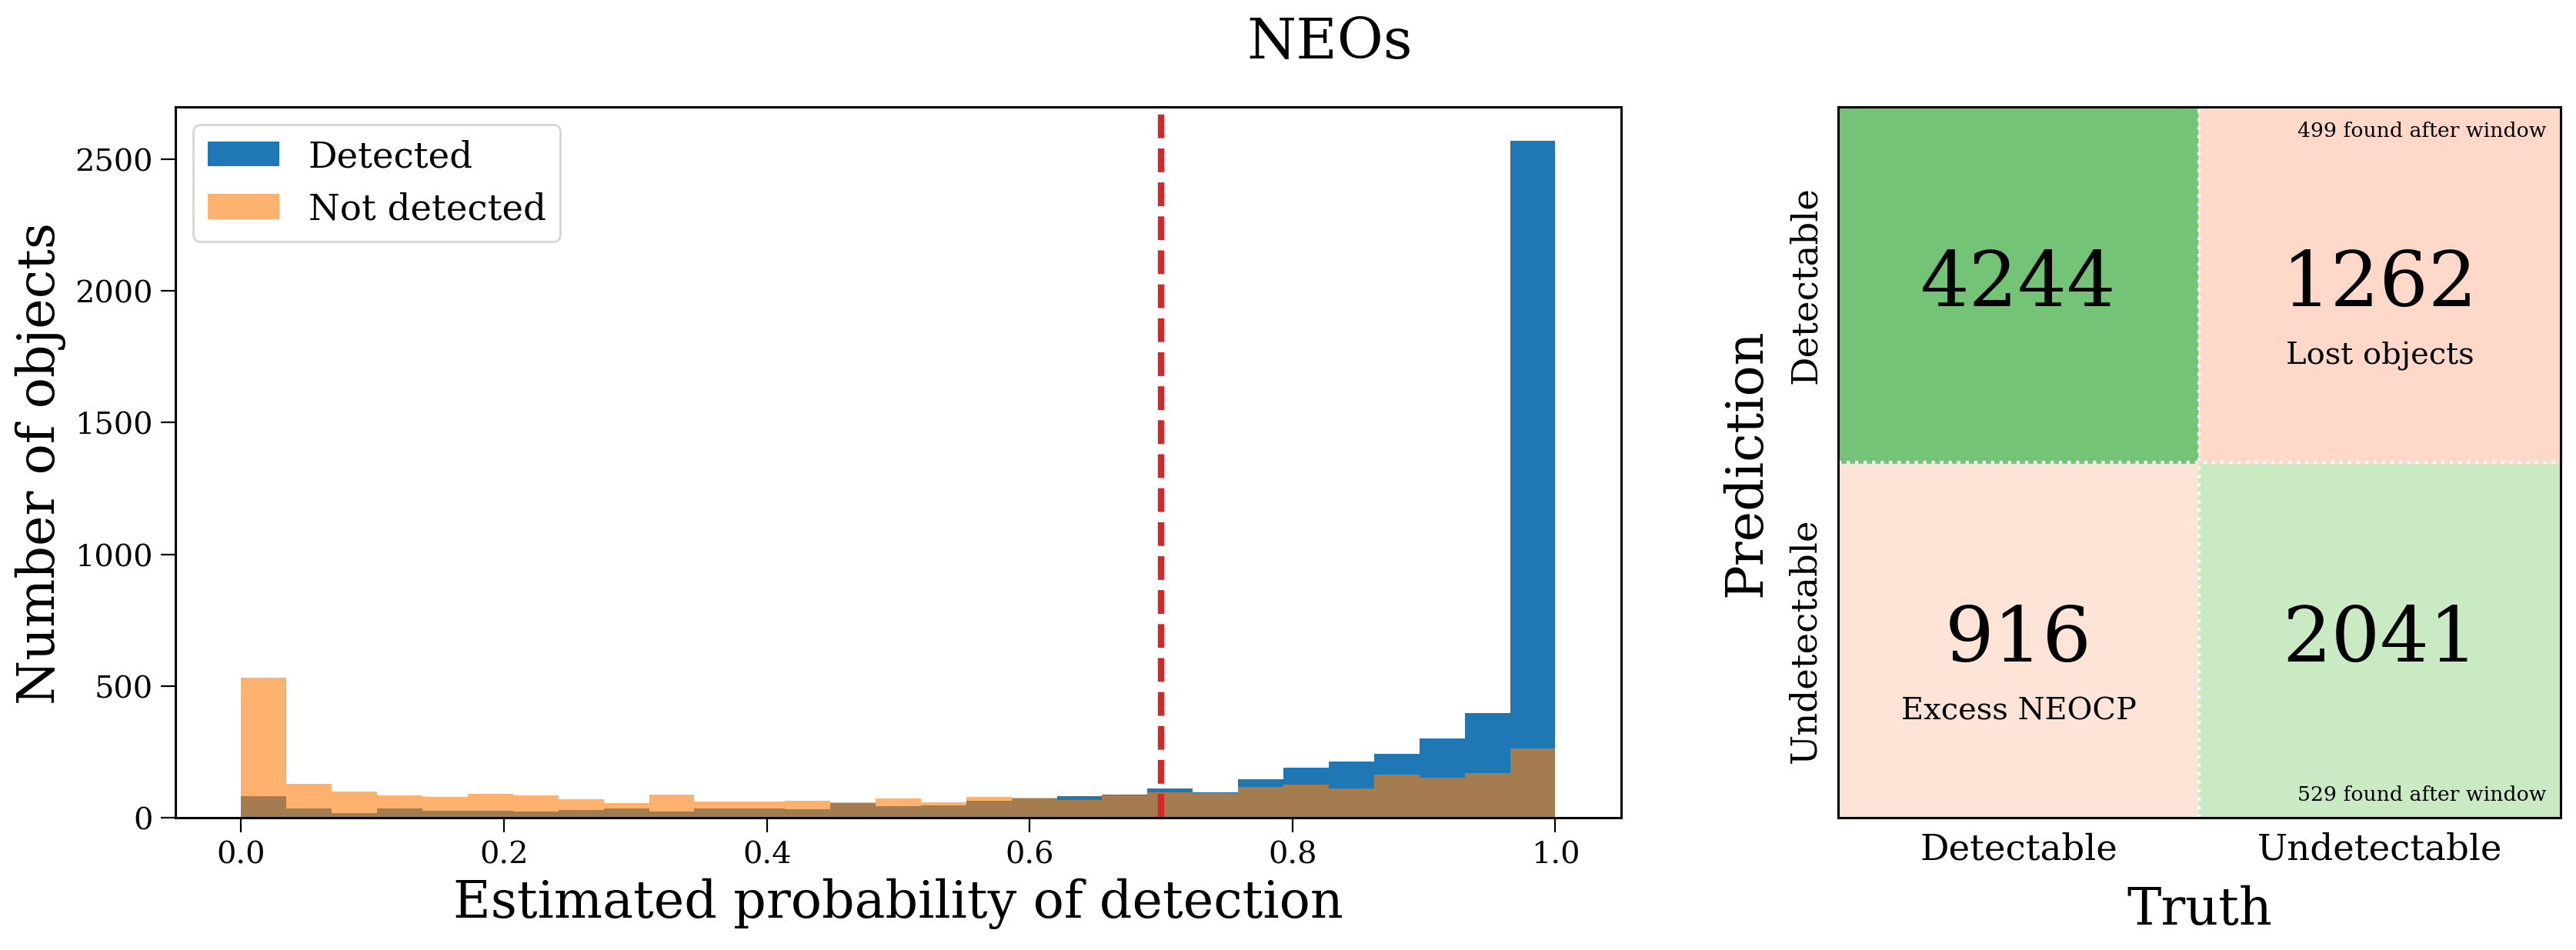

Of the 335646 objects, we classified
  256504 correctly
    208697 were detectable
    47807 were undetectable
  79142 incorrectly
    55087 were detectable
    24055 were undetectable
Overall success rate: 76.42%


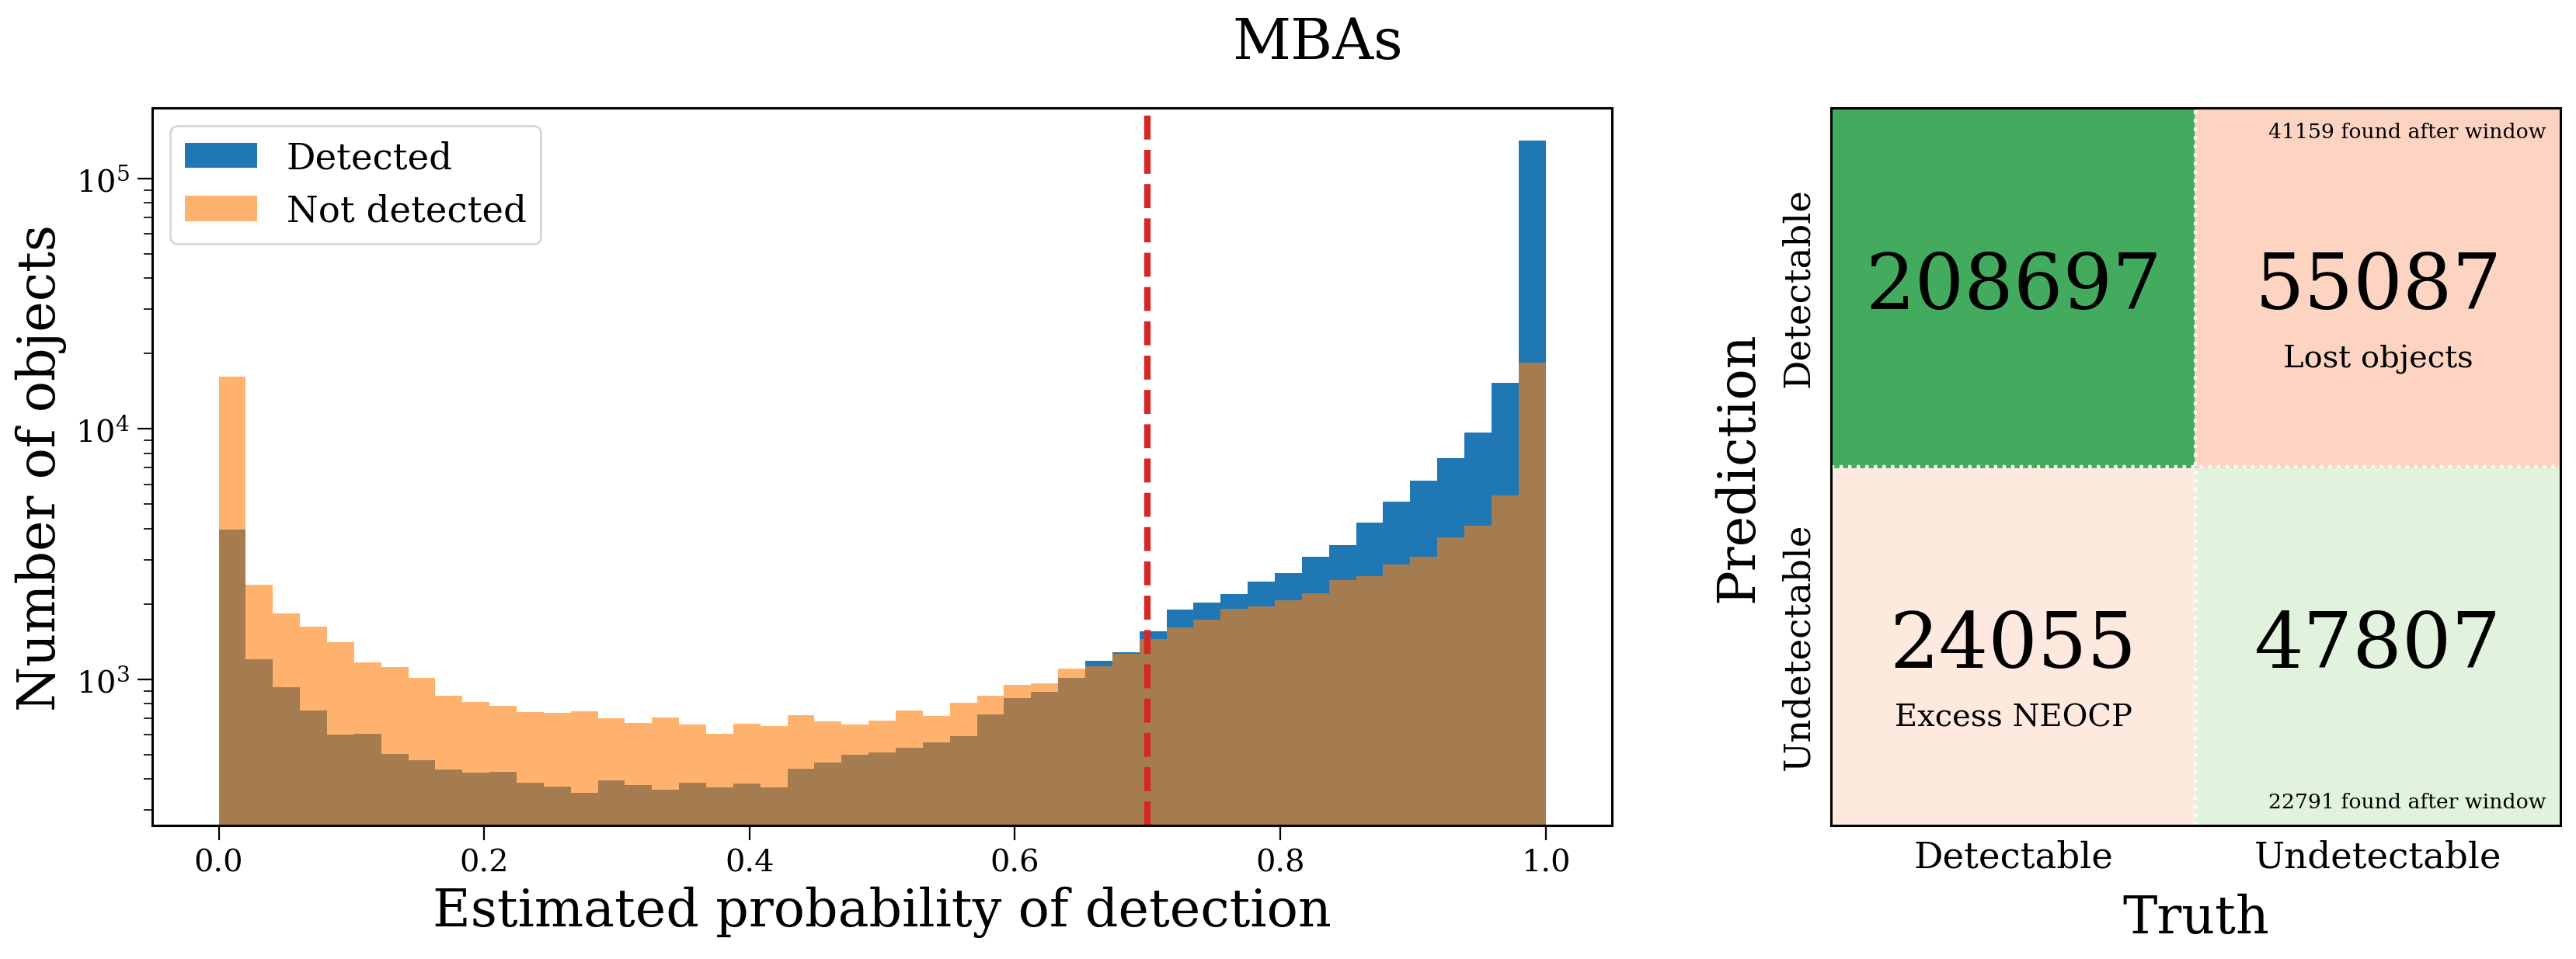

In [39]:
assess_algorithm_results(neo_results, threshold=0.7, obj_type="neo", bin_count=30, save_plot=True)
assess_algorithm_results(mba_results, threshold=0.7, obj_type="mba", save_plot=True)

Of the 10087 objects, we classified
  7419 correctly
    4896 were detectable
    2523 were undetectable
  2668 incorrectly
    1451 were detectable
    1217 were undetectable
Overall success rate: 73.55%


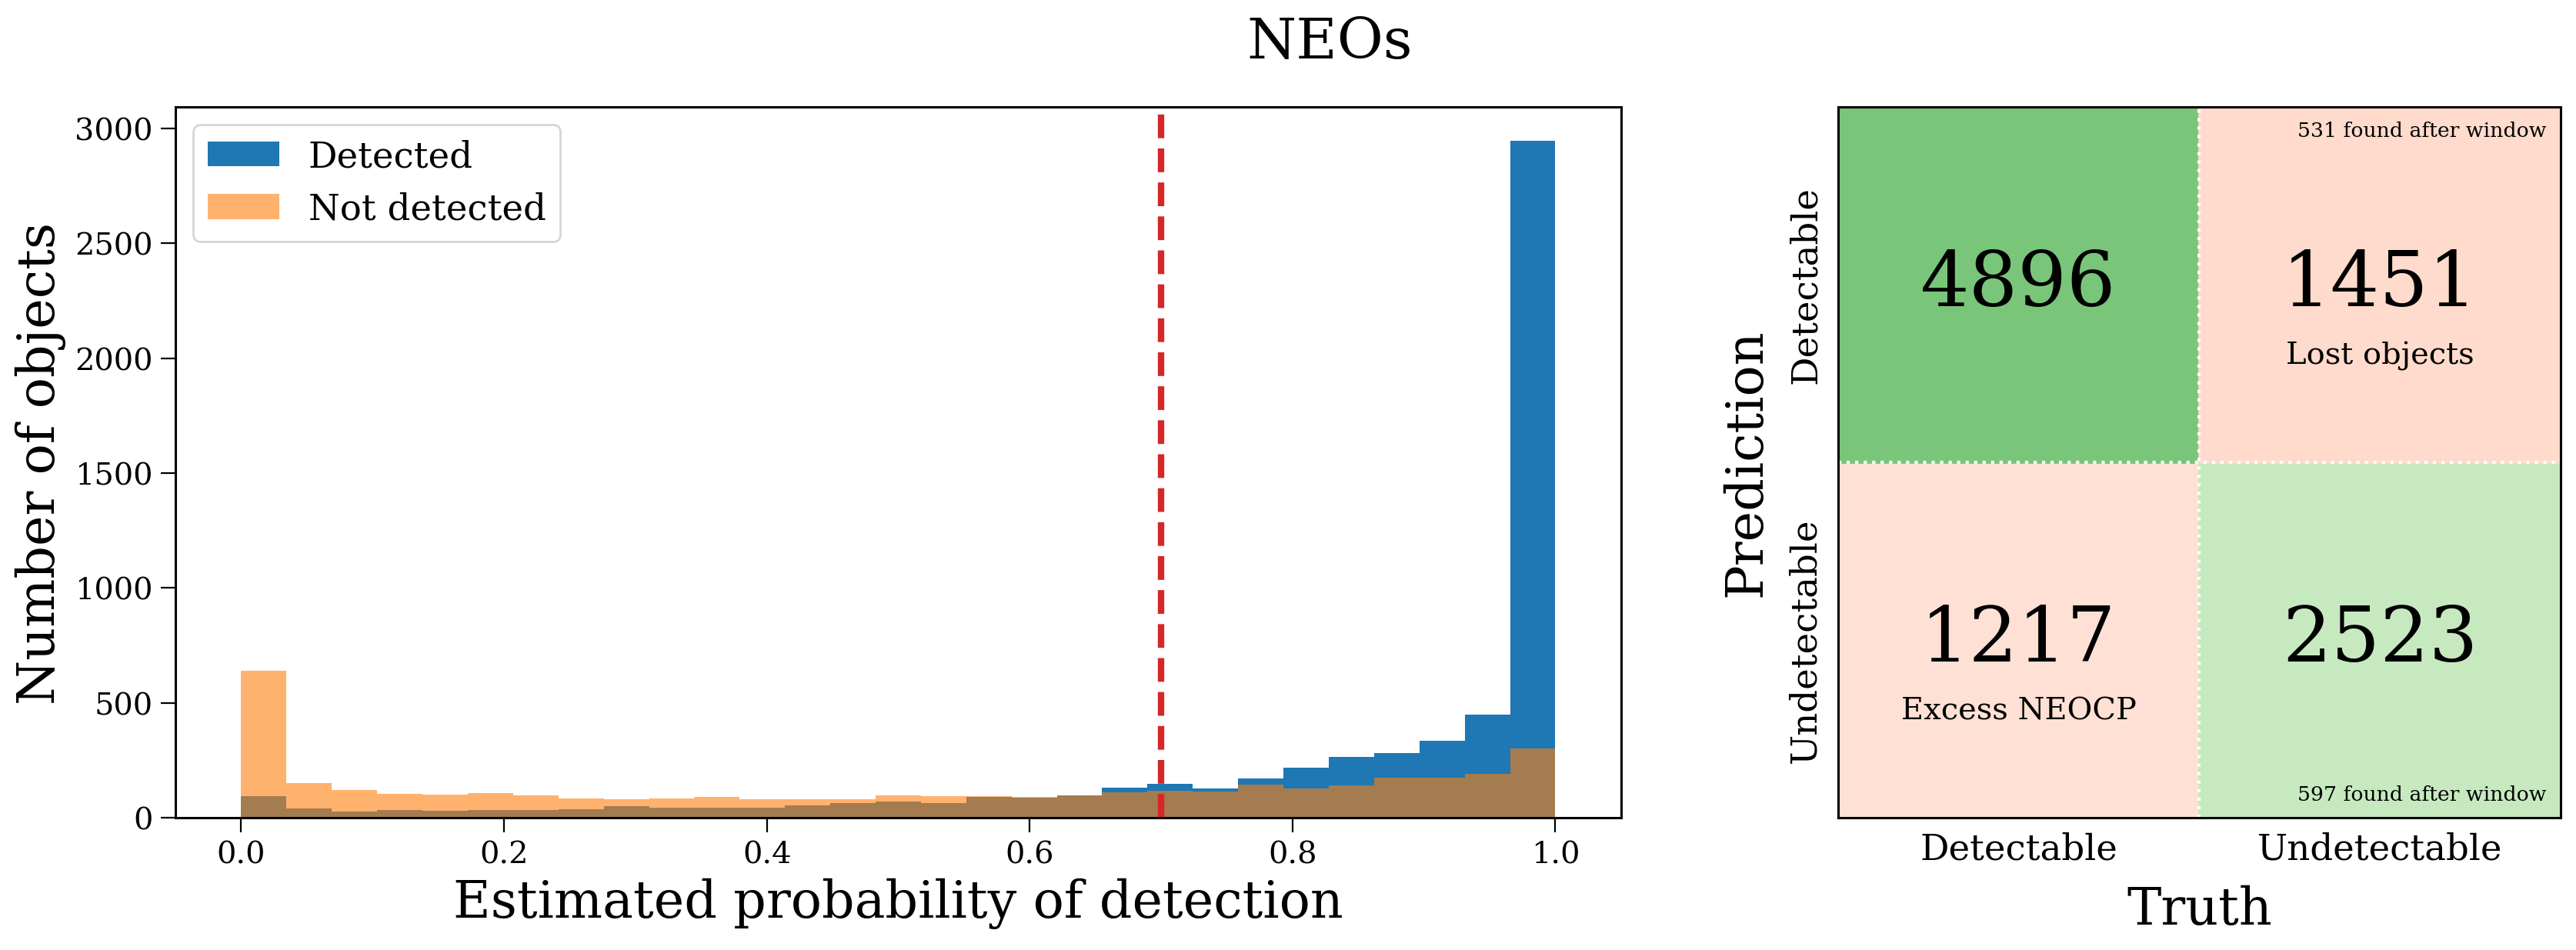

Of the 335646 objects, we classified
  256504 correctly
    208697 were detectable
    47807 were undetectable
  79142 incorrectly
    55087 were detectable
    24055 were undetectable
Overall success rate: 76.42%


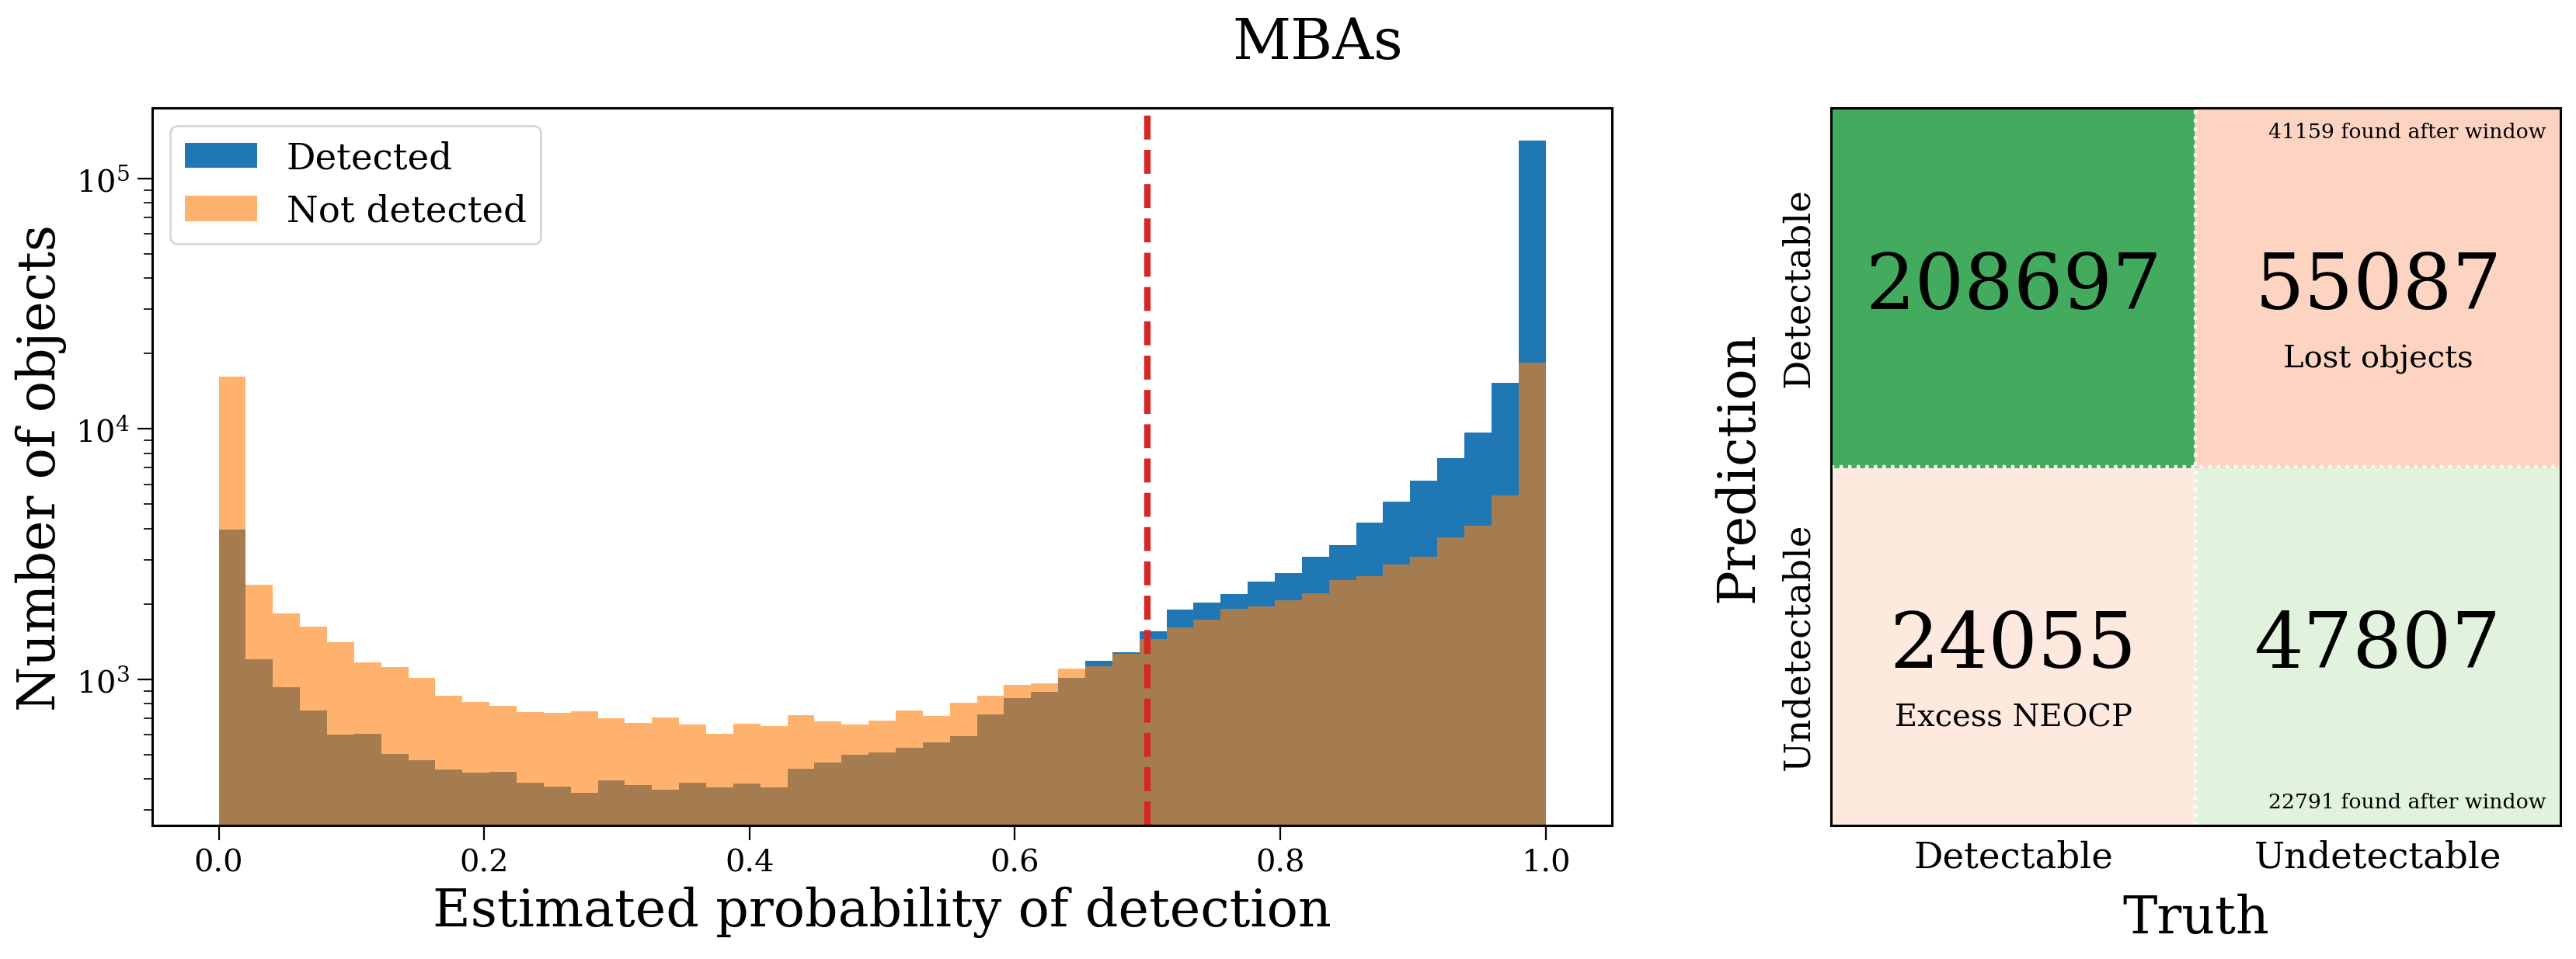

In [23]:
assess_algorithm_results(neo_results, threshold=0.7, obj_type="neo", bin_count=30, save_plot=True)
assess_algorithm_results(mba_results, threshold=0.7, obj_type="mba", save_plot=True)

## NEOs vs. MBAs

In [8]:
%%time
obs_dfs = [pd.read_hdf(f"../current_criteria/neo/filtered_visit_scores_{i:03d}.h5")
            for i in range(24)]
neo_obs = pd.concat(obs_dfs)
neo_obs = neo_obs[neo_obs["n_obs"] >= 3]

CPU times: user 1.18 s, sys: 56.5 ms, total: 1.23 s
Wall time: 3.15 s


In [9]:
%%time
obs_dfs = [pd.read_hdf(f"../current_criteria/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
mba_obs = pd.concat(obs_dfs)
mba_obs = mba_obs[mba_obs["n_obs"] >= 3]

CPU times: user 3min 23s, sys: 1min 48s, total: 5min 11s
Wall time: 5min 26s


In [10]:
neo_obs_dd = neo_obs.drop_duplicates(subset=["ObjID", "night"])
mba_obs_dd = mba_obs.drop_duplicates(subset=["ObjID", "night"])

## Plot setup

In [11]:
from matplotlib.patches import Patch

In [12]:
def compare_hists(var, label, ylabel, neo_obs, mba_obs,
                  bins="fd", density="both", figsize=(8, 16),
                  colours = {
                      "neo": list(plt.get_cmap("tab10")(1)),
                      "mba": list(plt.get_cmap("tab10")(4))
                  },
                  save_plot=None):
    neo_hist, var_bins = np.histogram(neo_obs[var], bins=bins, density=False)
    mba_hist, var_bins = np.histogram(mba_obs[var], bins=var_bins, density=False)

    handles = [Patch(facecolor=colours["neo"][:-1] + [0.2],
                         edgecolor=colours["neo"],
                         label="NEOs", lw=3),
               Patch(facecolor=colours["mba"][:-1] + [0.2],
                         edgecolor=colours["mba"],
                         label="MBAs", lw=3)]
    
    def _hists(ax, dens):
        ax.hist(neo_obs[var], bins=var_bins, density=dens, label="NEOs", facecolor=colours["neo"][:-1] + [0.2], lw=3)
        ax.hist(neo_obs[var], bins=var_bins, density=dens, color=colours["neo"], histtype="step", lw=3)

        ax.hist(mba_obs[var], bins=var_bins, density=dens, label="MBAs", facecolor=colours["mba"][:-1] + [0.2], lw=3)
        ax.hist(mba_obs[var], bins=var_bins, density=dens, color=colours["mba"], histtype="step", lw=3)
        ax.legend(handles=handles, loc="upper center", ncol=2, fontsize=0.8 * fs)

        if dens:
            ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}$" + ylabel)
        else:
            ax.set_yscale("log")
            ax.set_ylabel("Number of objects")
    
    if density == "both":
        fig, axes = plt.subplots(3, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 2, 1]}, sharex=True)
        for ax, dens in zip(axes[:-1], [True, False]):
            _hists(ax, dens)
    else:
        fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 1]}, sharex=True)
        _hists(axes[0], density)
    
    centres = (var_bins[1:] + var_bins[:-1]) / 2
    axes[-1].plot(centres[mba_hist > 0], neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0], marker="o")
    centres = (var_bins[1:] + var_bins[:-1]) / 2
    axes[-1].scatter(centres[mba_hist <= 0],
                     np.repeat(max(neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0]), (mba_hist <= 0).sum()),
                     marker=r"$\infty$", color="tab:blue", zorder=10)
    axes[-1].set_yscale("log")
    axes[-1].set_xlabel(label)
    axes[-1].set_ylabel(r"$N_{\rm NEO}/N_{\rm MBA}$")
    axes[-1].grid()
    
    if np.any(neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0] >= 1.0):
        axes[-1].axhline(1.0, linestyle="dotted", color="grey")
        
    for ax in axes[:-1]:
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
    axes[0].annotate("a", xy=(0.02, 0.98), xycoords="axes fraction", fontsize=0.5*fs, va="top",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))
    axes[1].annotate("b", xy=(0.98, 0.98), xycoords="axes fraction", fontsize=0.5*fs, va="top", ha="right",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))
    axes[2].annotate("c", xy=(0.02, 0.96), xycoords="axes fraction", fontsize=0.5*fs, va="top",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))    
        
    if save_plot is not None:
        plt.savefig(save_plot, format="pdf", bbox_inches="tight")

    plt.show()

In [10]:
f'{len(neo_obs_dd[neo_obs_dd["scores"] >= 65]) / (len(neo_obs_dd[neo_obs_dd["scores"] >= 65]) + len(mba_obs_dd[mba_obs_dd["scores"] >= 65])) * 100:1.1f}%'

'3.0%'

In [27]:
even_top_score = (len(neo_obs_dd[neo_obs_dd["scores"] == 100])
    / (len(neo_obs_dd[neo_obs_dd["scores"] == 100]) + len(mba_obs_dd[mba_obs_dd["scores"] == 100])) * 100)
f'{even_top_score:1.1f}%'

'20.3%'

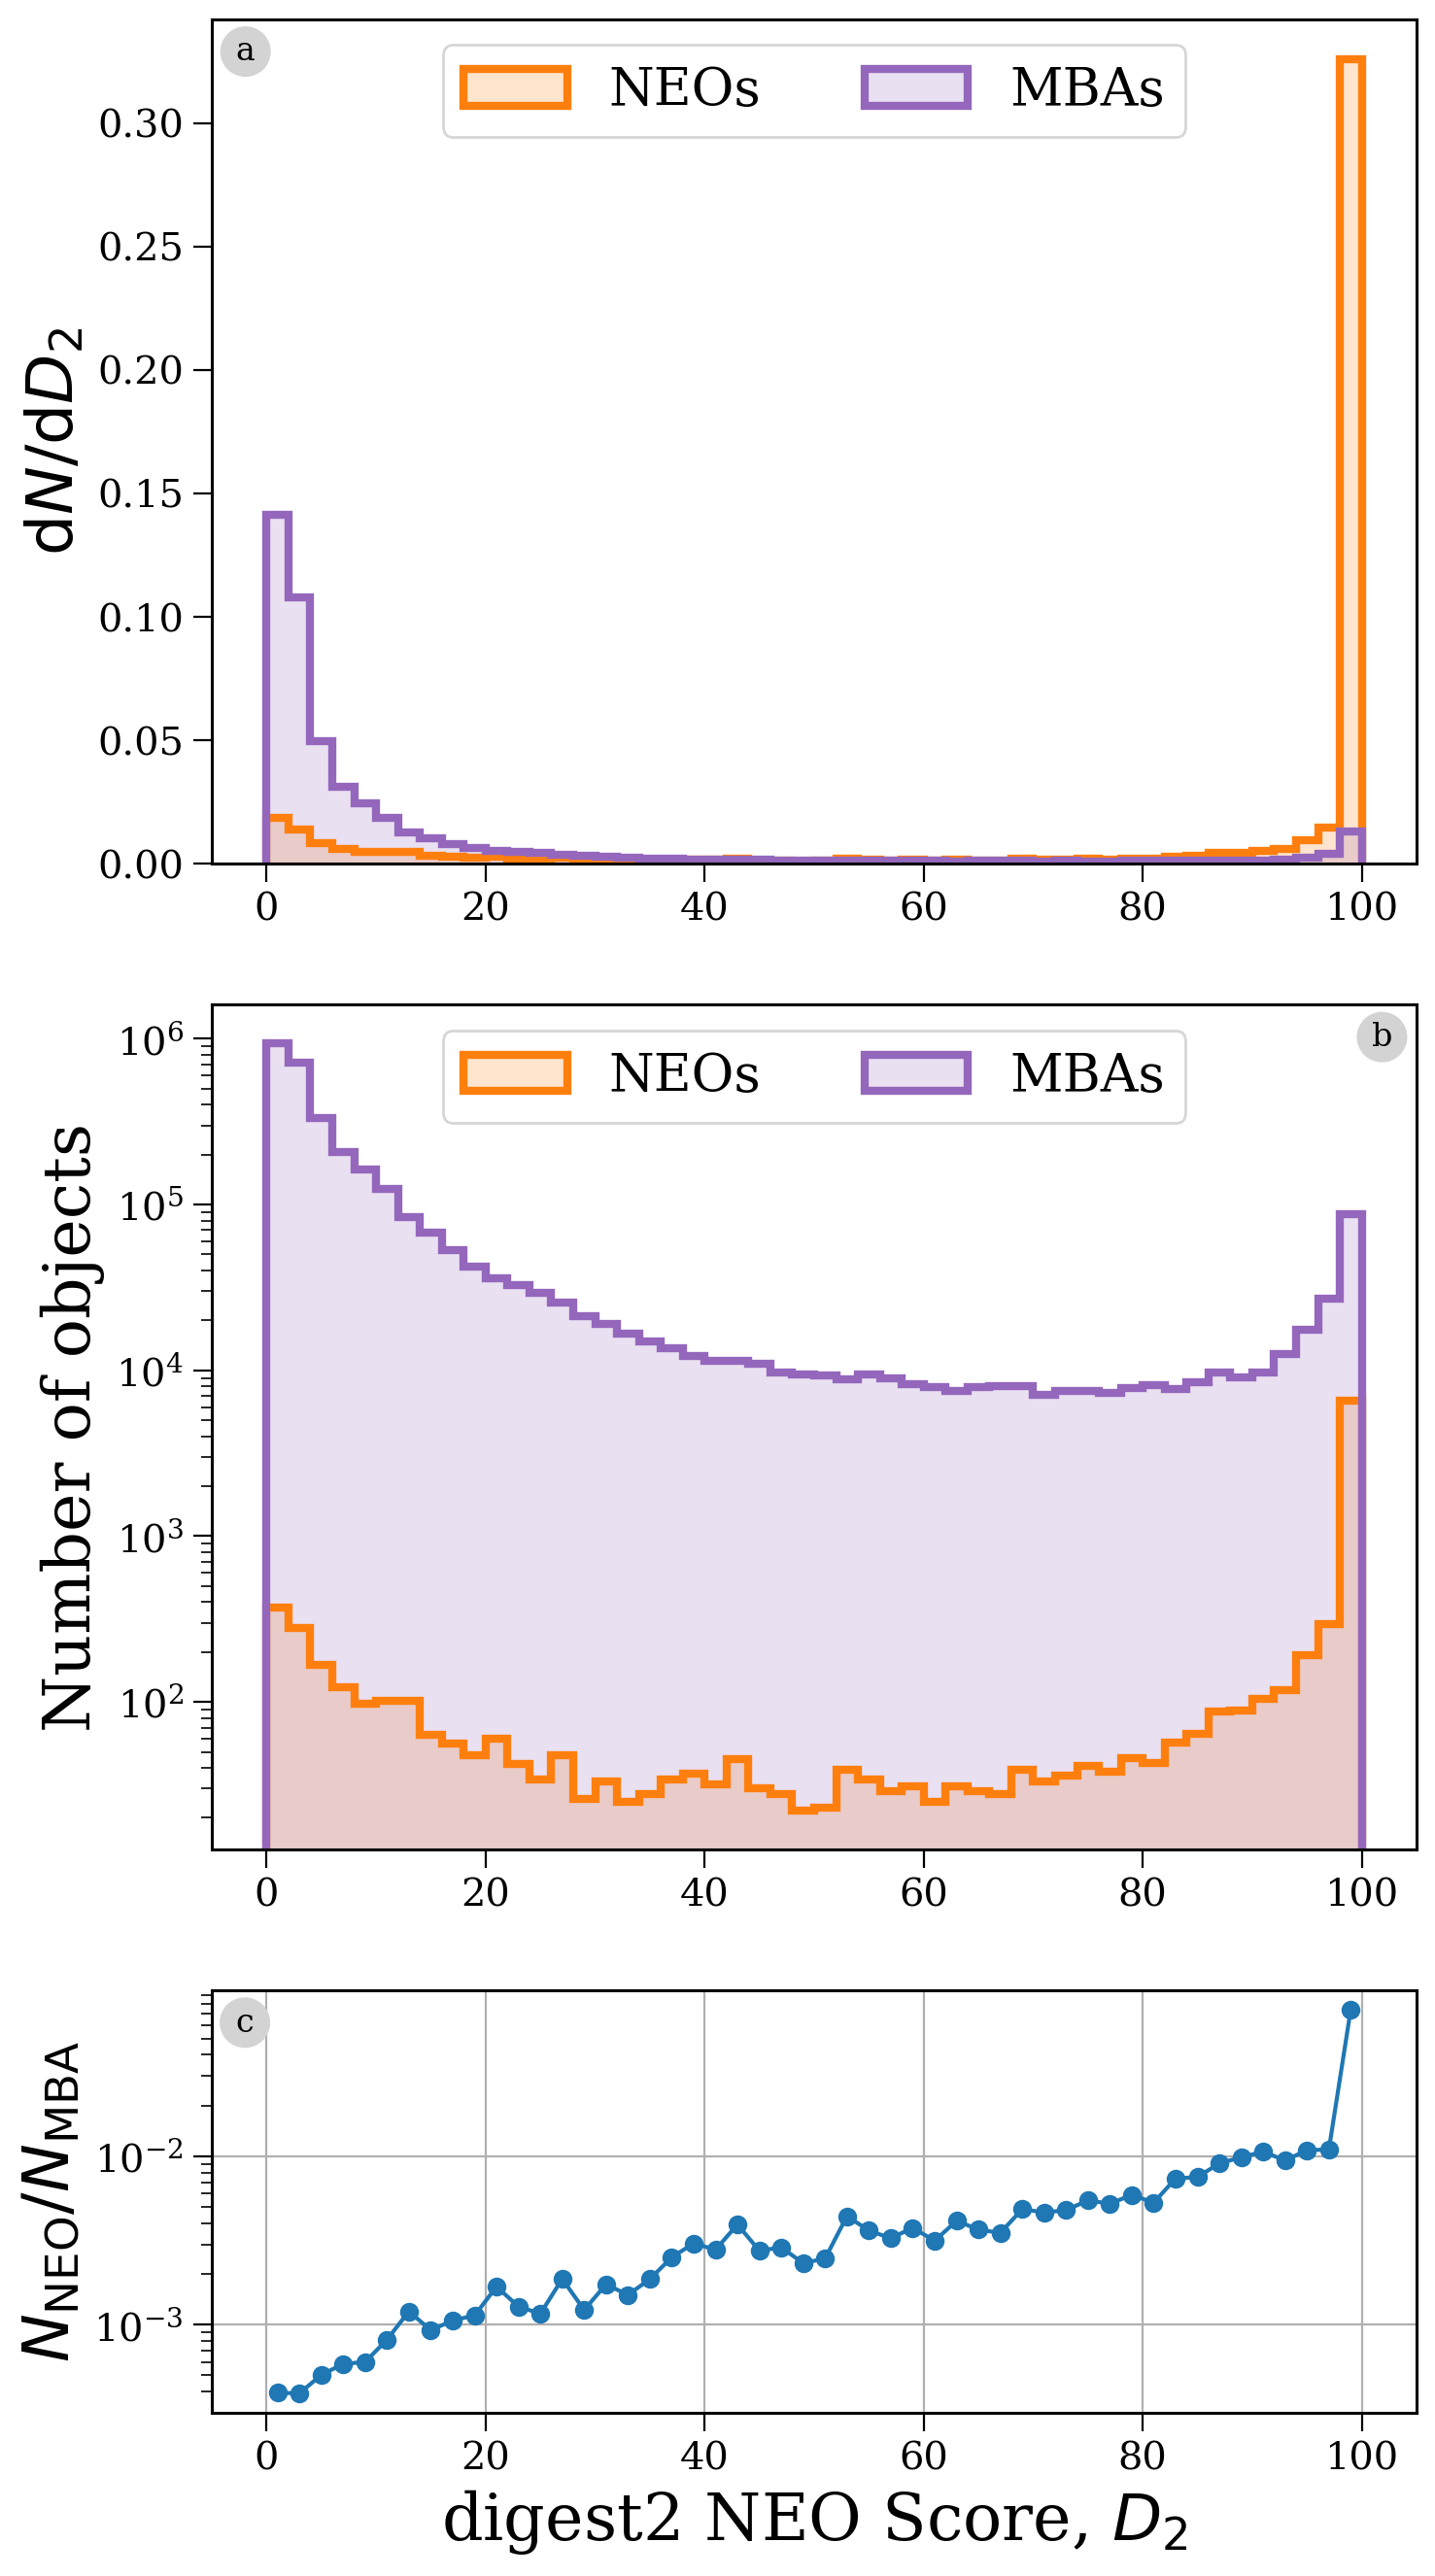

CPU times: user 1.91 s, sys: 26.5 ms, total: 1.94 s
Wall time: 2.46 s


In [24]:
%%time
compare_hists("scores", r"digest2 NEO Score, $D_2$", r"$D_2$", neo_obs_dd, mba_obs_dd, density="both", bins=np.linspace(0, 100, 51), figsize=(8, 16), save_plot="../paper/figures/digest2_pollution.pdf")

### Magnitude things

In [11]:
%%time
obs_dfs = [pd.read_hdf(f"../neocp/neo/filtered_visit_scores_{i:03d}.h5")
            for i in range(24)]
neo_obs = pd.concat(obs_dfs)
neo_obs = neo_obs[(neo_obs["scores"] >= 65) & (neo_obs["n_obs"] >= 3)]

CPU times: user 8.77 s, sys: 4.5 s, total: 13.3 s
Wall time: 15.6 s


In [12]:
%%time
obs_dfs = [pd.read_hdf(f"../neocp/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
mba_obs = pd.concat(obs_dfs)
mba_obs = mba_obs[(mba_obs["scores"] >= 65) & (mba_obs["n_obs"] >= 3)]

CPU times: user 5min 4s, sys: 2min 1s, total: 7min 6s
Wall time: 7min 19s


In [13]:
neo_obs_dd = neo_obs.drop_duplicates(subset="ObjID")
mba_obs_dd = mba_obs.drop_duplicates(subset="ObjID")

In [31]:
v_mag = np.ones(len(neo_obs)) * np.inf
for filter_letter in "ugrizy":
    filter_mask = neo_obs["filter"] == filter_letter
    if filter_mask.any():
        v_mag[filter_mask] = magnitudes.convert_colour_mags(neo_obs[filter_mask]["MaginFilter"],
                                                            out_colour=filter_letter,
                                                            in_colour="V", convention="LSST",
                                                            asteroid_type="C")
neo_obs["v_mag"] = v_mag

In [16]:
v_mag = np.ones(len(mba_obs)) * np.inf
for filter_letter in "ugrizy":
    print(filter_letter)
    filter_mask = mba_obs["filter"] == filter_letter
    if filter_mask.any():
        v_mag[filter_mask] = magnitudes.convert_colour_mags(mba_obs[filter_mask]["MaginFilter"],
                                                         out_colour=filter_letter,
                                                         in_colour="V", convention="LSST",
                                                         asteroid_type="C")
mba_obs["v_mag"] = v_mag

u
g
r
i
z
y


In [17]:
obs_hexs = np.concatenate((neo_obs.index.unique().values, mba_obs.index.unique().values))

In [20]:
%%time
s3m_matches = s3m_cart[s3m_cart["hex_id"].isin(obs_hexs)]

CPU times: user 8.97 s, sys: 921 ms, total: 9.89 s
Wall time: 9.8 s


In [21]:
neo_obs = neo_obs.join(other=s3m_matches["H"], on="ObjID")
mba_obs = mba_obs.join(other=s3m_matches["H"], on="ObjID")

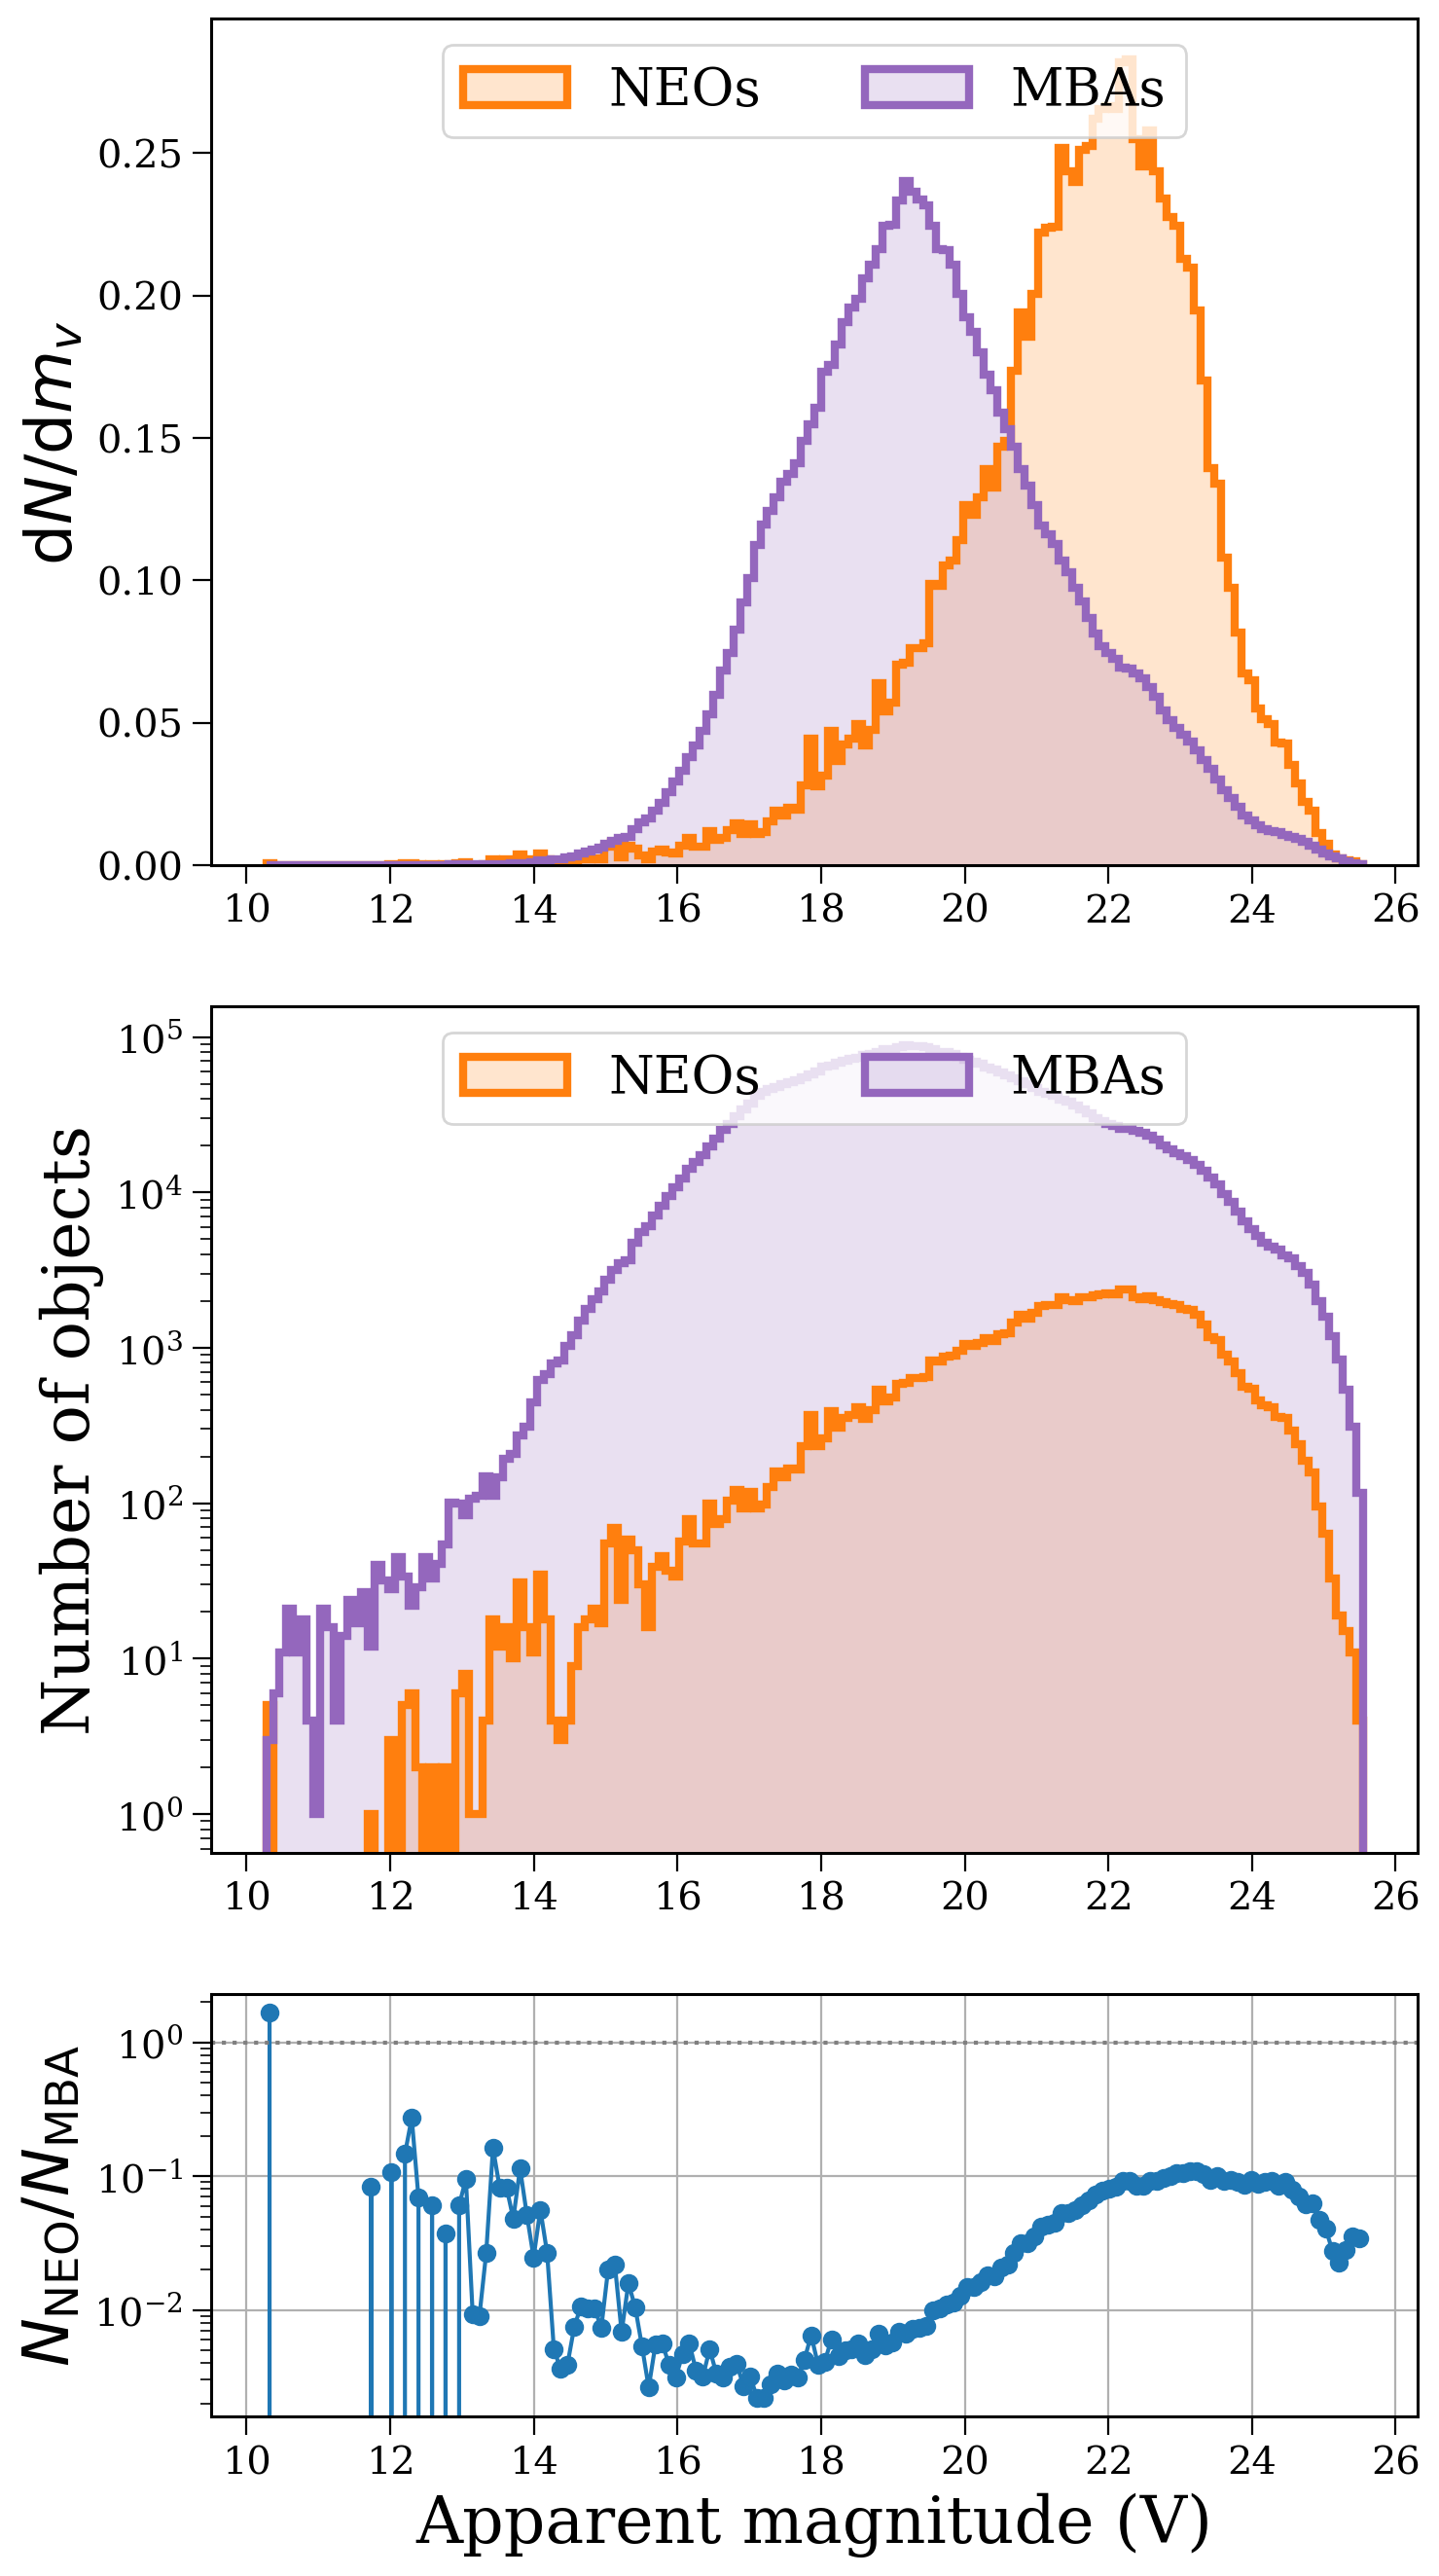

CPU times: user 4.82 s, sys: 119 ms, total: 4.94 s
Wall time: 4.94 s


In [366]:
%%time
compare_hists("v_mag", "Apparent magnitude (V)", r"$m_v$", neo_obs, mba_obs, density="both", figsize=(8, 16))

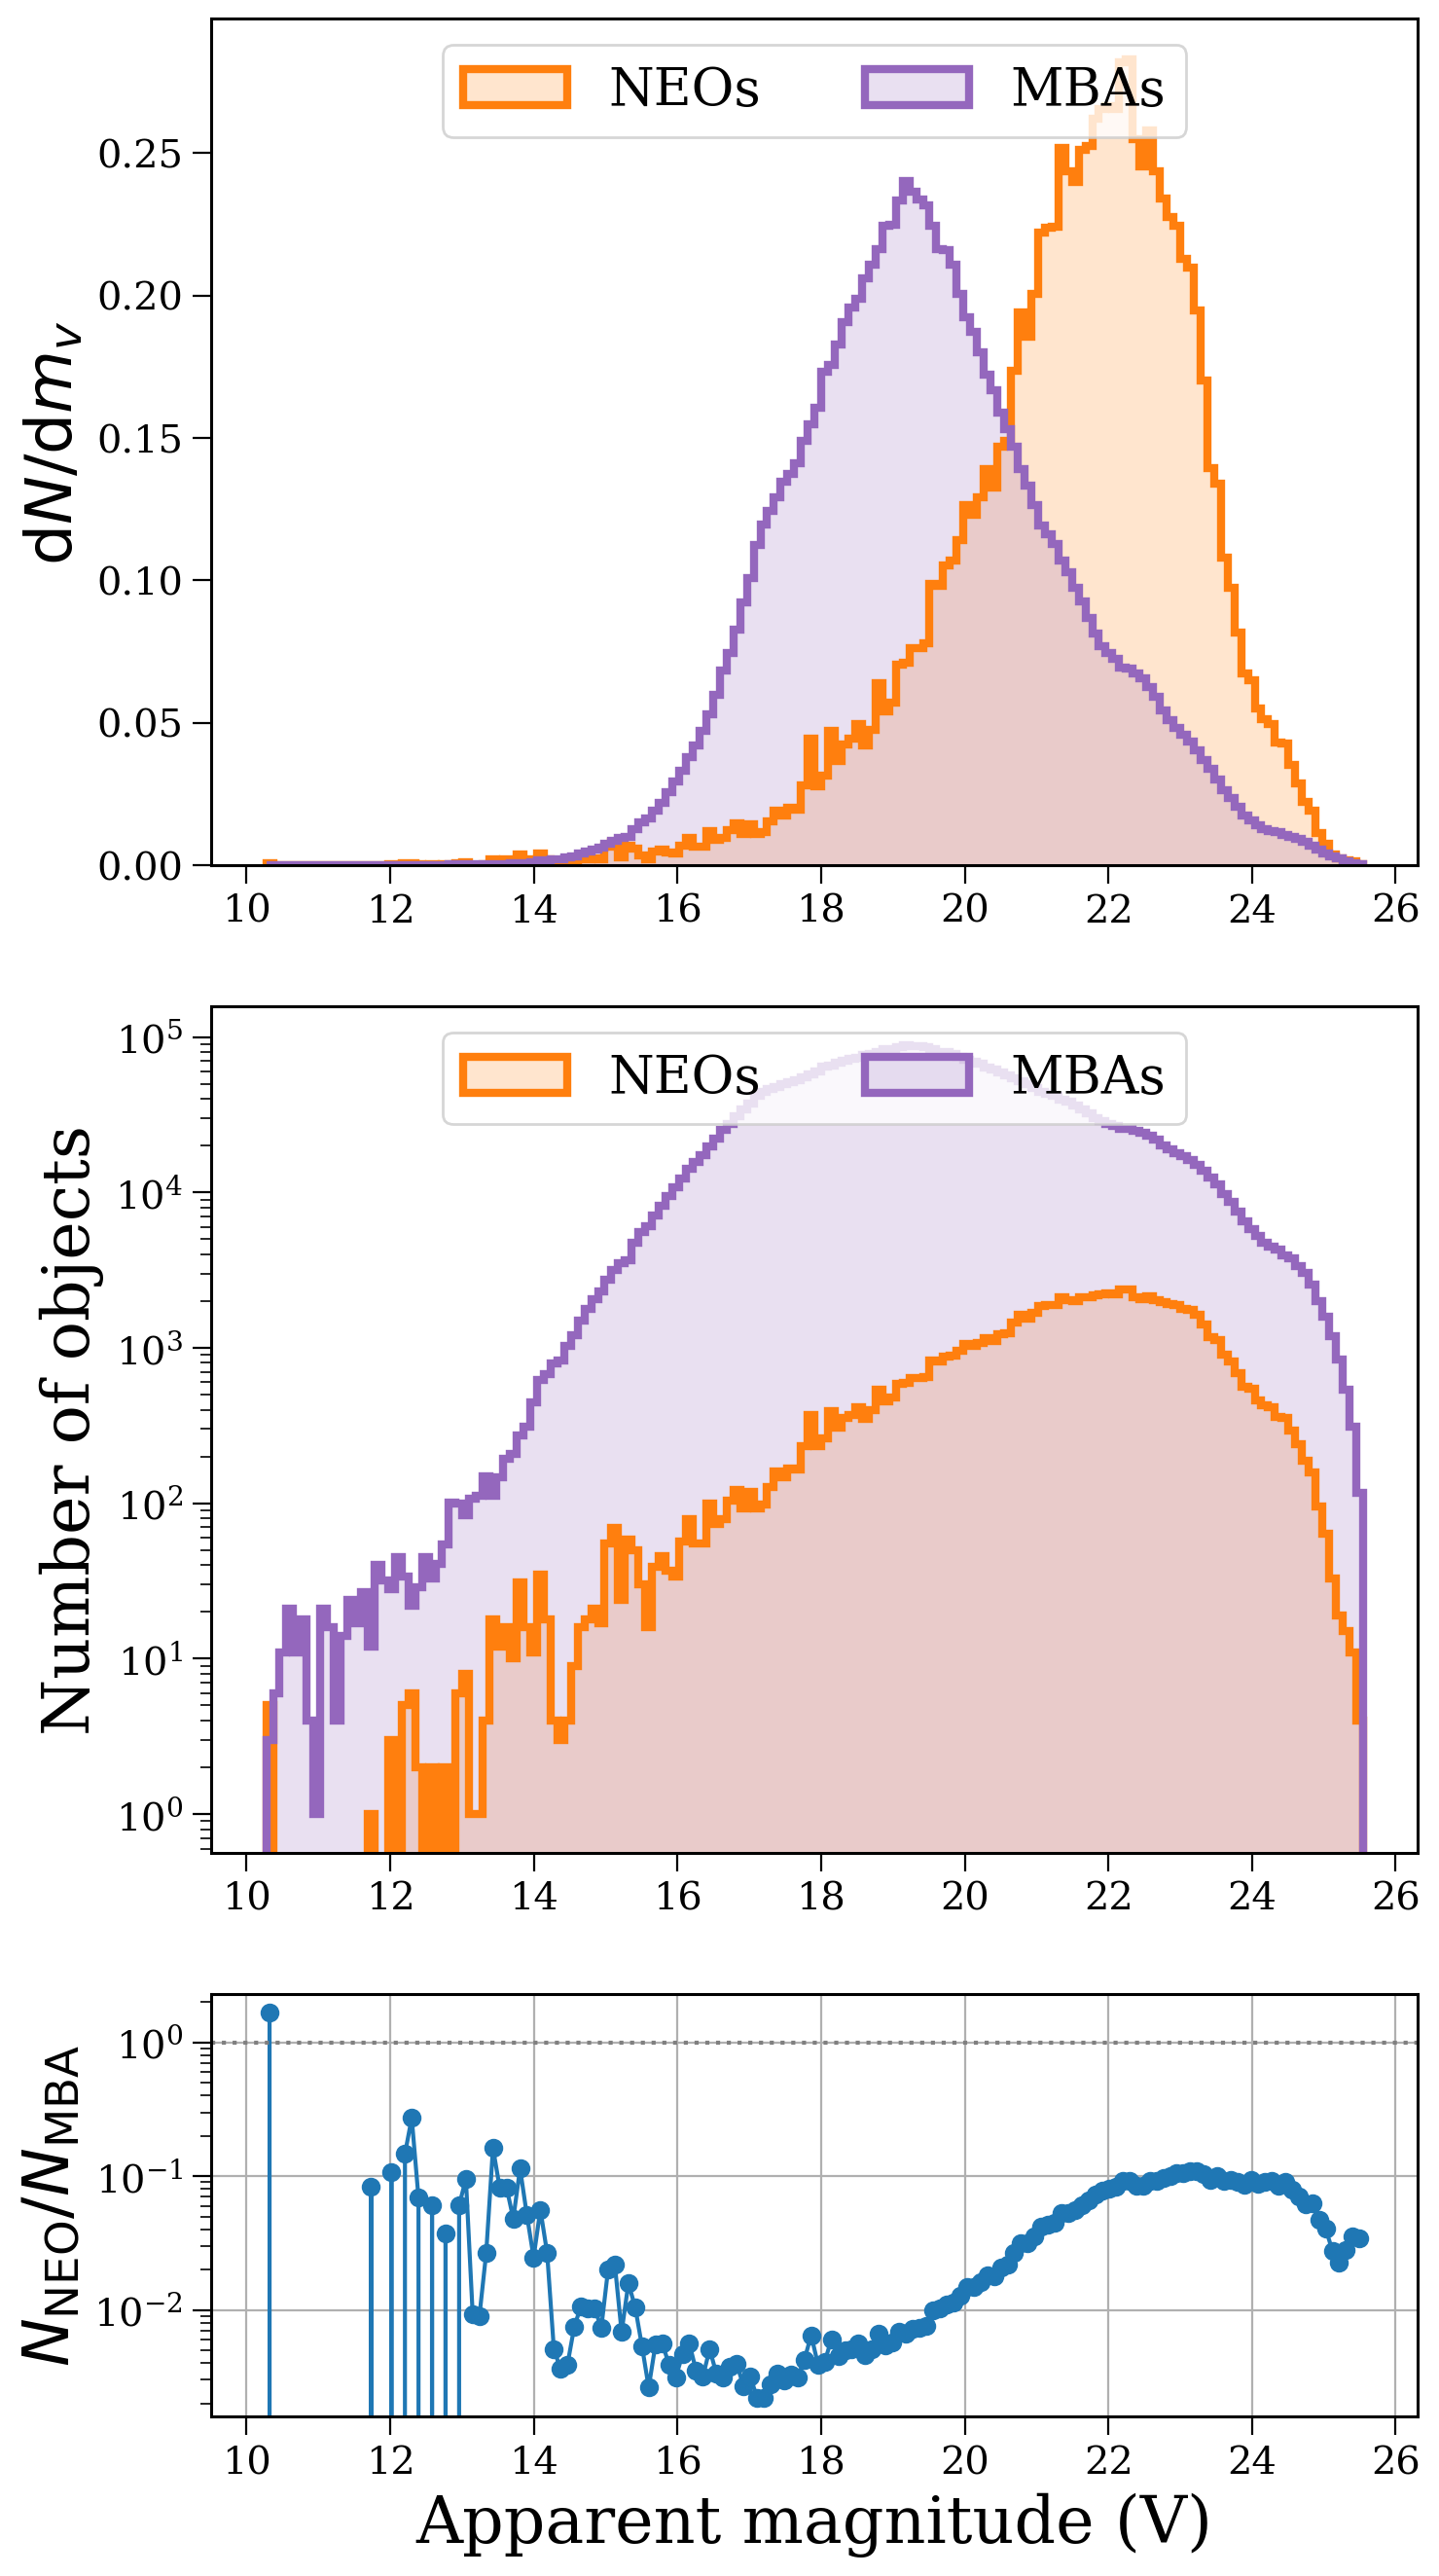

CPU times: user 4.82 s, sys: 119 ms, total: 4.94 s
Wall time: 4.94 s


In [366]:
%%time
compare_hists("H", "Absolute magnitude, $H$", r"$H$", neo_obs, mba_obs, density="both", figsize=(8, 16))

# Ecliptic Latitude cut for year 1

In [13]:
epsilon = 23.4392811*np.pi/180 #obliquity
def ecliptic_latitude(alpha, delta):
    return np.rad2deg(np.arcsin(np.cos(epsilon) * np.sin(delta) - np.sin(epsilon) * np.cos(delta) * np.sin(alpha)))

In [14]:
neo_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(neo_obs_dd["AstRA(deg)"]),
                                          np.deg2rad(neo_obs_dd["AstDec(deg)"]))
mba_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(mba_obs_dd["AstRA(deg)"]),
                                          np.deg2rad(mba_obs_dd["AstDec(deg)"]))

/tmp/ipykernel_26994/2377206901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neo_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(neo_obs_dd["AstRA(deg)"]),
/tmp/ipykernel_26994/2377206901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mba_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(mba_obs_dd["AstRA(deg)"]),


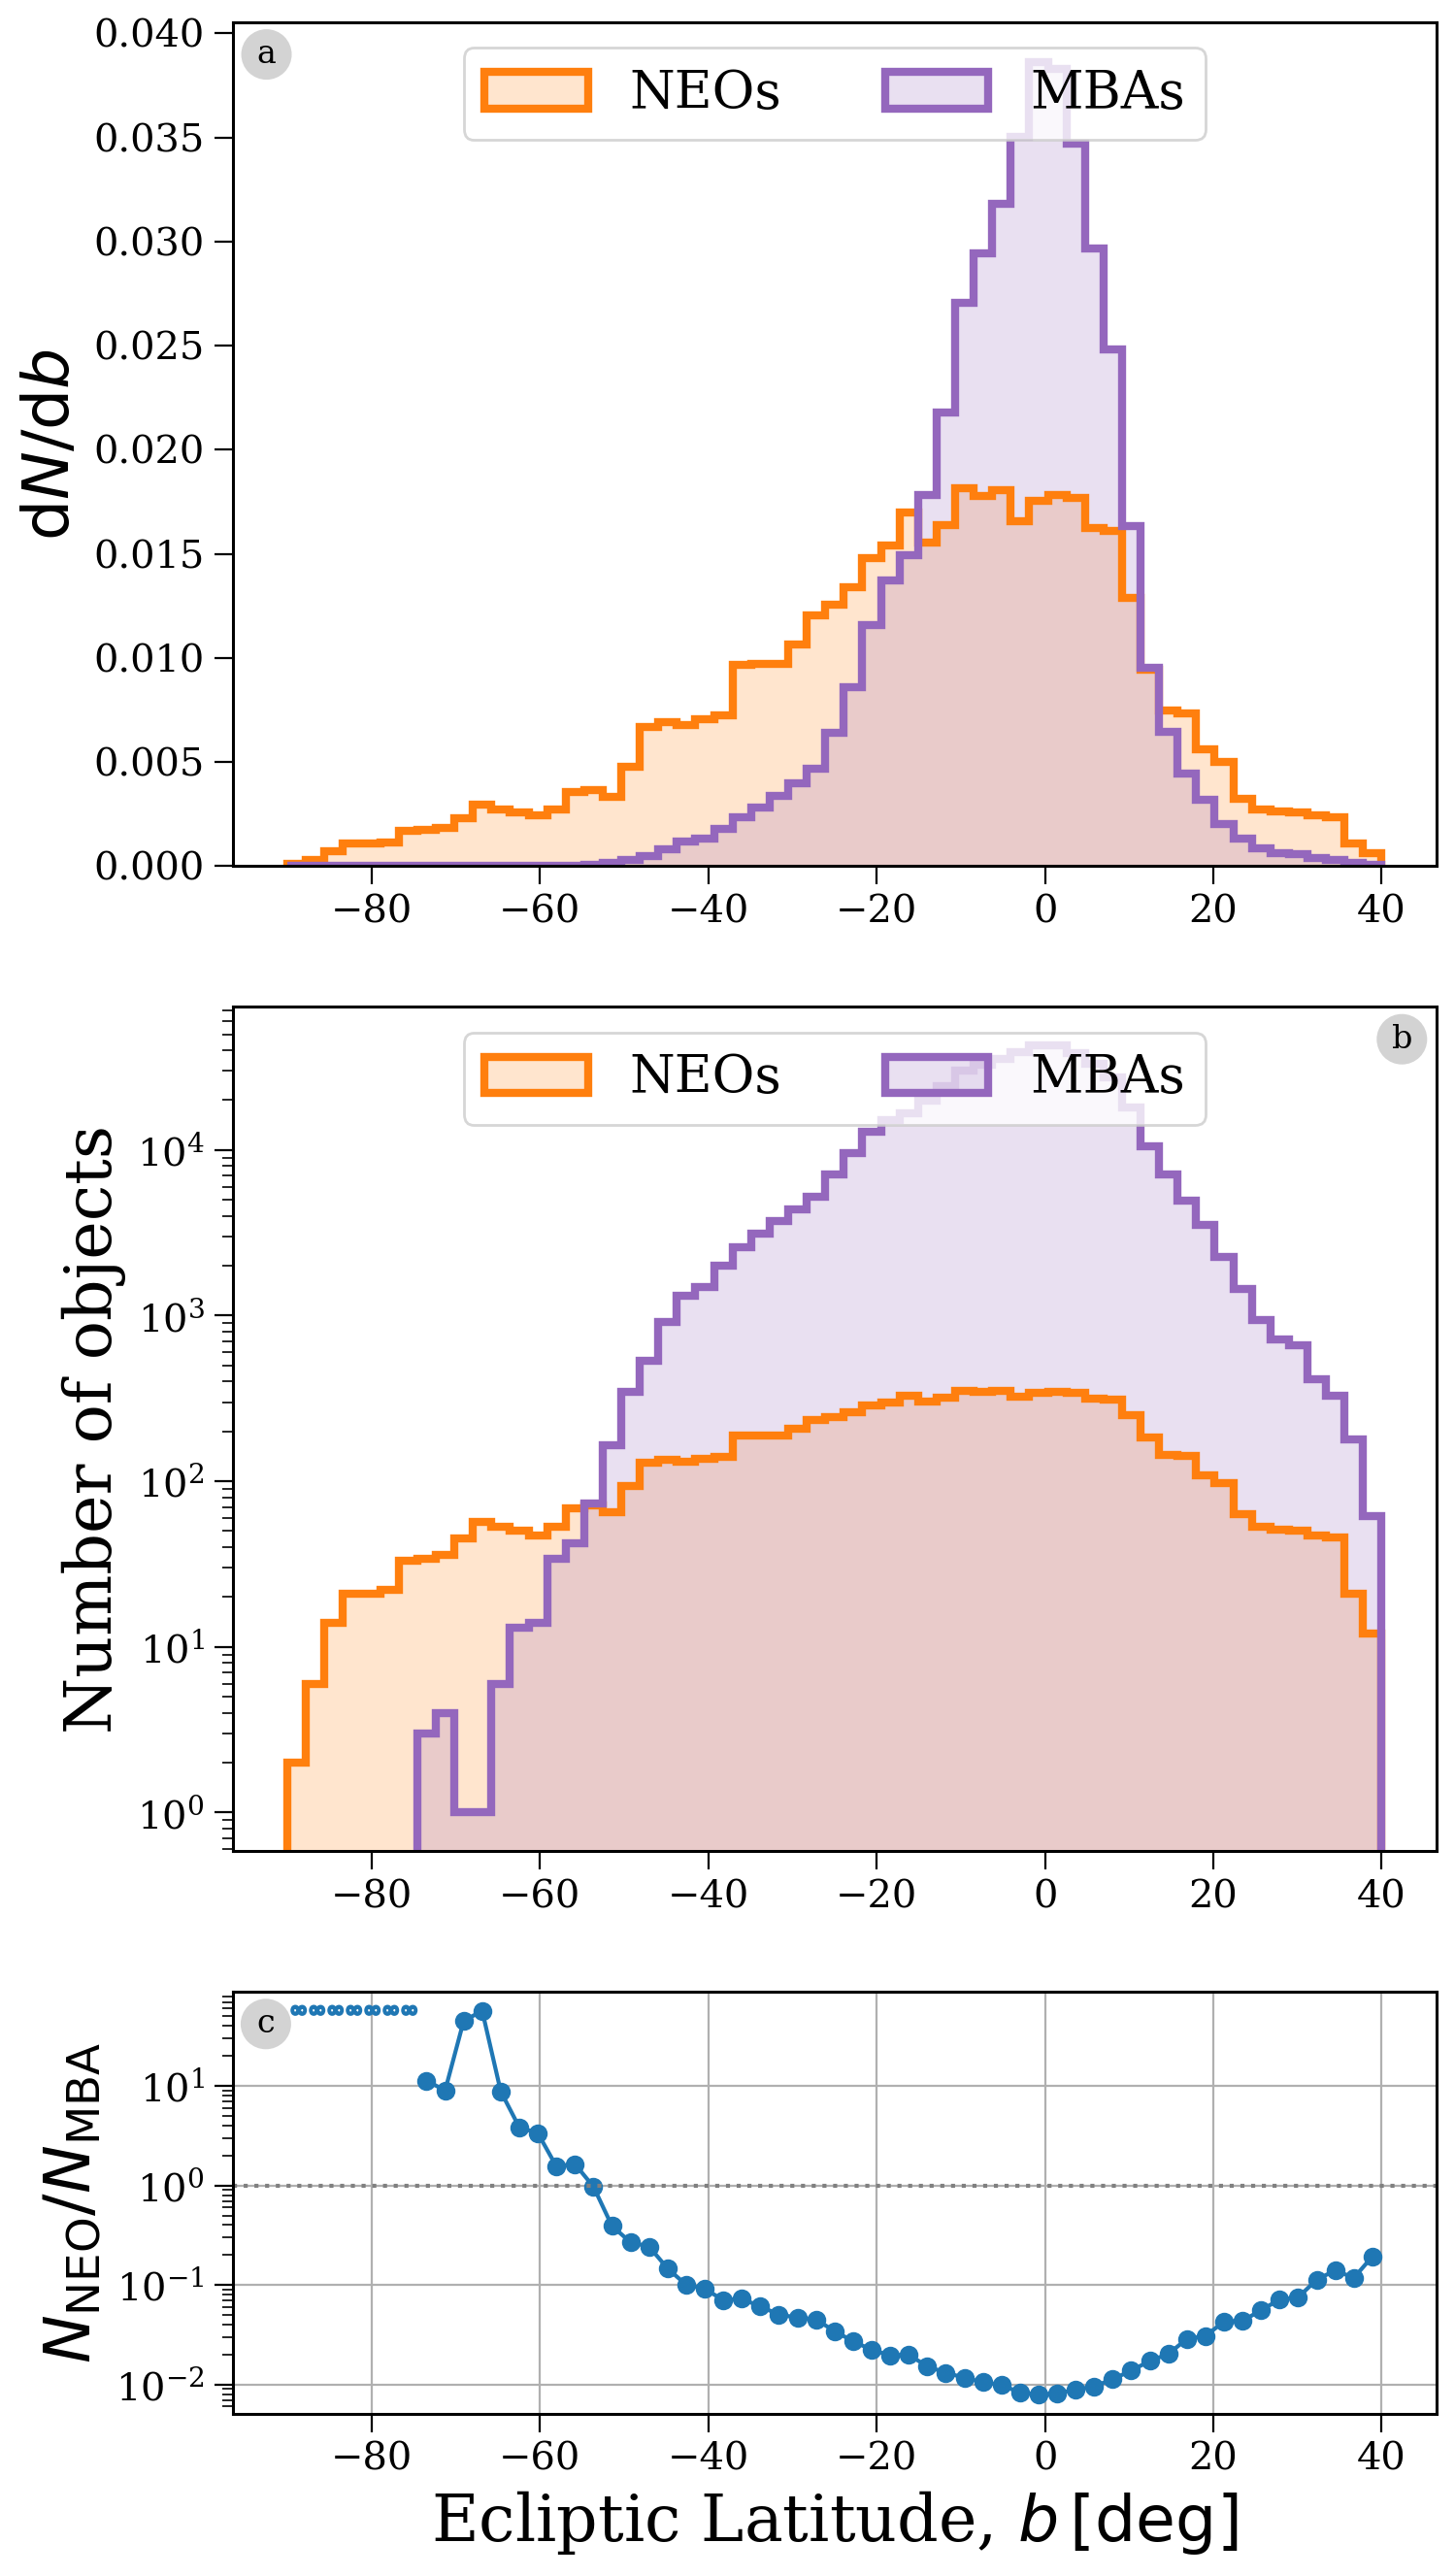

In [86]:
compare_hists("ecl_lat", r"Ecliptic Latitude, $b \, [\rm deg]$", r"$b$", neo_obs_dd, mba_obs_dd,
              bins=np.linspace(-90, 40, 60))

In [15]:
def first_year_stats_unique(neo_obs, mba_obs, cutoff):
    n_neo = len(neo_obs[neo_obs["ecl_lat"] <= cutoff].index.unique())
    n_mba = len(mba_obs[mba_obs["ecl_lat"] <= cutoff].index.unique())
    return n_neo + n_mba, n_neo / (n_neo + n_mba)

def first_year_stats(neo_obs, mba_obs, cutoff):
    n_neo = (abs(neo_obs["ecl_lat"]) >= cutoff).sum()
    n_mba = (abs(mba_obs["ecl_lat"]) >= cutoff).sum()
    avg_mag = np.median(np.concatenate((neo_obs["MaginFilter"][abs(neo_obs["ecl_lat"]) >= cutoff],
                                        mba_obs["MaginFilter"][abs(mba_obs["ecl_lat"]) >= cutoff])))
    return n_neo + n_mba, n_neo / (n_neo + n_mba), avg_mag

In [27]:
%%time
cutoffs = np.linspace(0, abs(min(neo_obs_dd["ecl_lat"])), 1000)
first_year_traffic = np.zeros_like(cutoffs)
first_year_purity = np.zeros_like(cutoffs)

neo_obs_dd_neocp = neo_obs_dd[neo_obs_dd["scores"] >= 65]
mba_obs_dd_neocp = mba_obs_dd[mba_obs_dd["scores"] >= 65]

for i in range(len(cutoffs)):
    first_year_traffic[i], first_year_purity[i], _ = first_year_stats(neo_obs_dd_neocp,
                                                                      mba_obs_dd_neocp,
                                                                      cutoffs[i])

CPU times: user 37.7 s, sys: 2.67 s, total: 40.4 s
Wall time: 31 s


In [68]:
ecl_lat_data = ",".join(list(cutoffs.astype('str'))) + "\n"\
+ ",".join((first_year_traffic / 377).astype('str')) + "\n"\
+ ",".join((first_year_purity * 100).astype('str'))

In [69]:
with open("ecl_lat_data.csv", "w") as f:
    f.write(ecl_lat_data)

In [26]:
((mba_obs_dd["scores"] >= 65).sum() + (neo_obs_dd["scores"] >= 65).sum()) / 377

3862.9840848806366

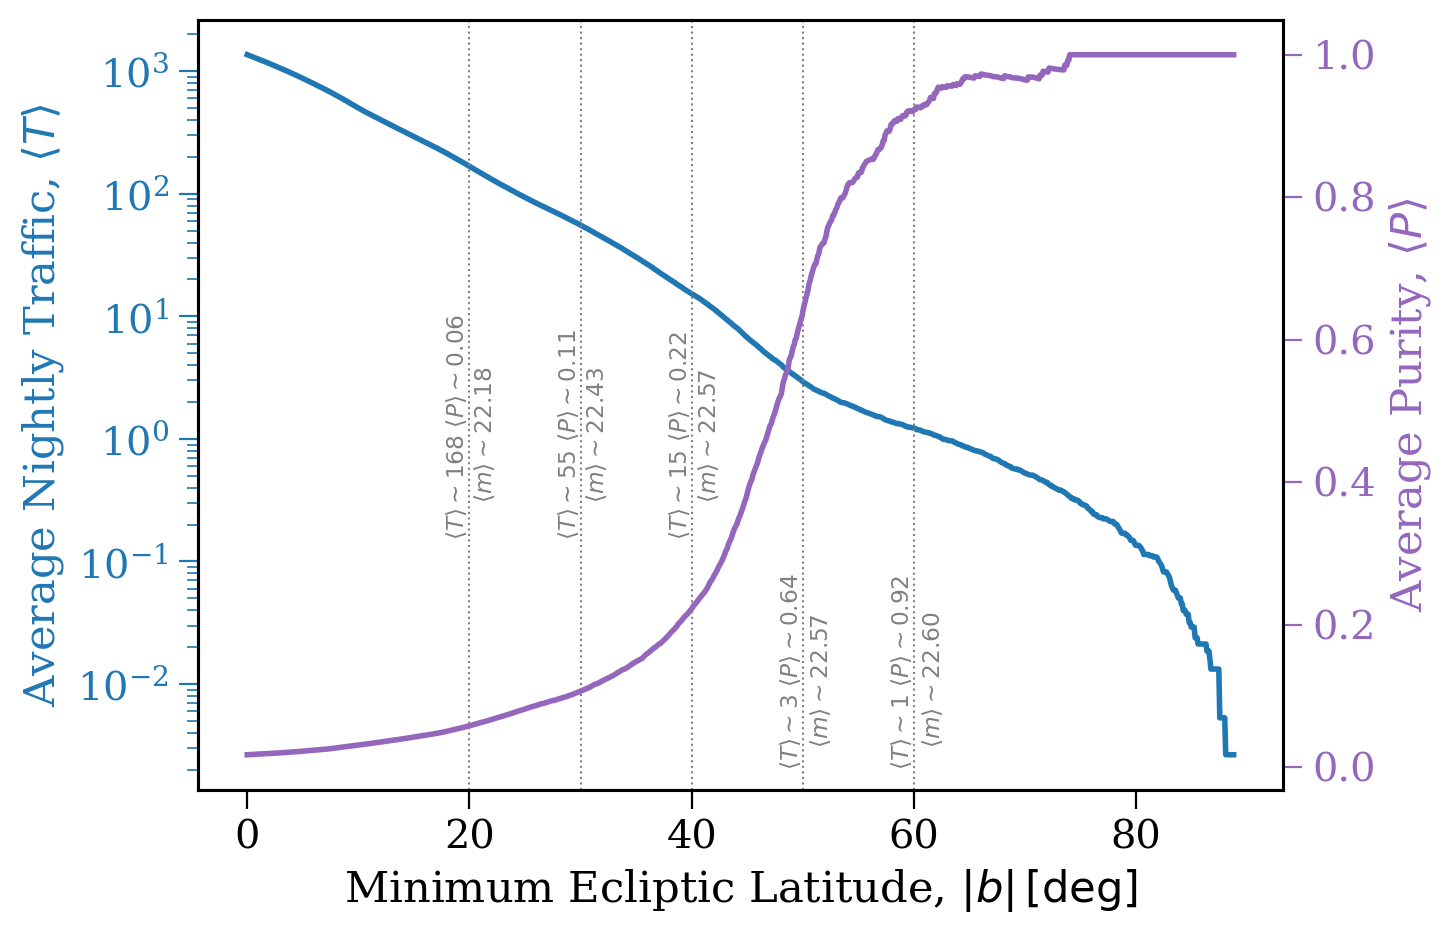

In [257]:
fig, ax = plt.subplots(figsize=(7, 5))

left_col = "tab:blue"
right_col = "tab:purple"

ax.plot(cutoffs, first_year_traffic / 377, lw=2)
ax.set_yscale("log")
ax.set_ylabel(r"Average Nightly Traffic, $\langle T \rangle$", fontsize=0.65*fs, color=left_col)

ax_right = ax.twinx()
ax_right.plot(cutoffs, first_year_purity, color=right_col, lw=2)
ax_right.set_ylabel(r"Average Purity, $\langle P \rangle$", fontsize=0.65*fs, color=right_col)
ax.set_xlabel(r"Minimum Ecliptic Latitude, $|b| \, {\rm [deg]}$", fontsize=0.65*fs)

ax.tick_params(axis="y", which="both", colors=left_col)
ax_right.tick_params(axis="y", which="both", colors=right_col)

for lim in range(20, 60 + 10, 10):
    t, p, am = first_year_stats(neo_obs_dd, mba_obs_dd, lim)
    ax.axvline(lim, color="grey", linestyle="dotted", lw=0.75)
    y_val = 2e-3 if lim >= 50 else 1.5e-1
    y_val2 = 3e-3 if lim >= 50 else 3e-1
    ax.annotate(rf"$\langle T \rangle{{\sim}}{{{t / 377:1.0f}}}$ $\langle P \rangle{{\sim}}{{{p:1.2f}}}$",
                xy=(lim, y_val), rotation=90, ha="right", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    ax.annotate(rf"$\langle m \rangle{{\sim}}{{{am:1.2f}}}$",
                xy=(lim * 1.01, y_val2), rotation=90, ha="left", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    
plt.savefig("../paper/figures/ecliptic_latitude_cutoff.pdf", format="pdf", bbox_inches="tight")
plt.show()

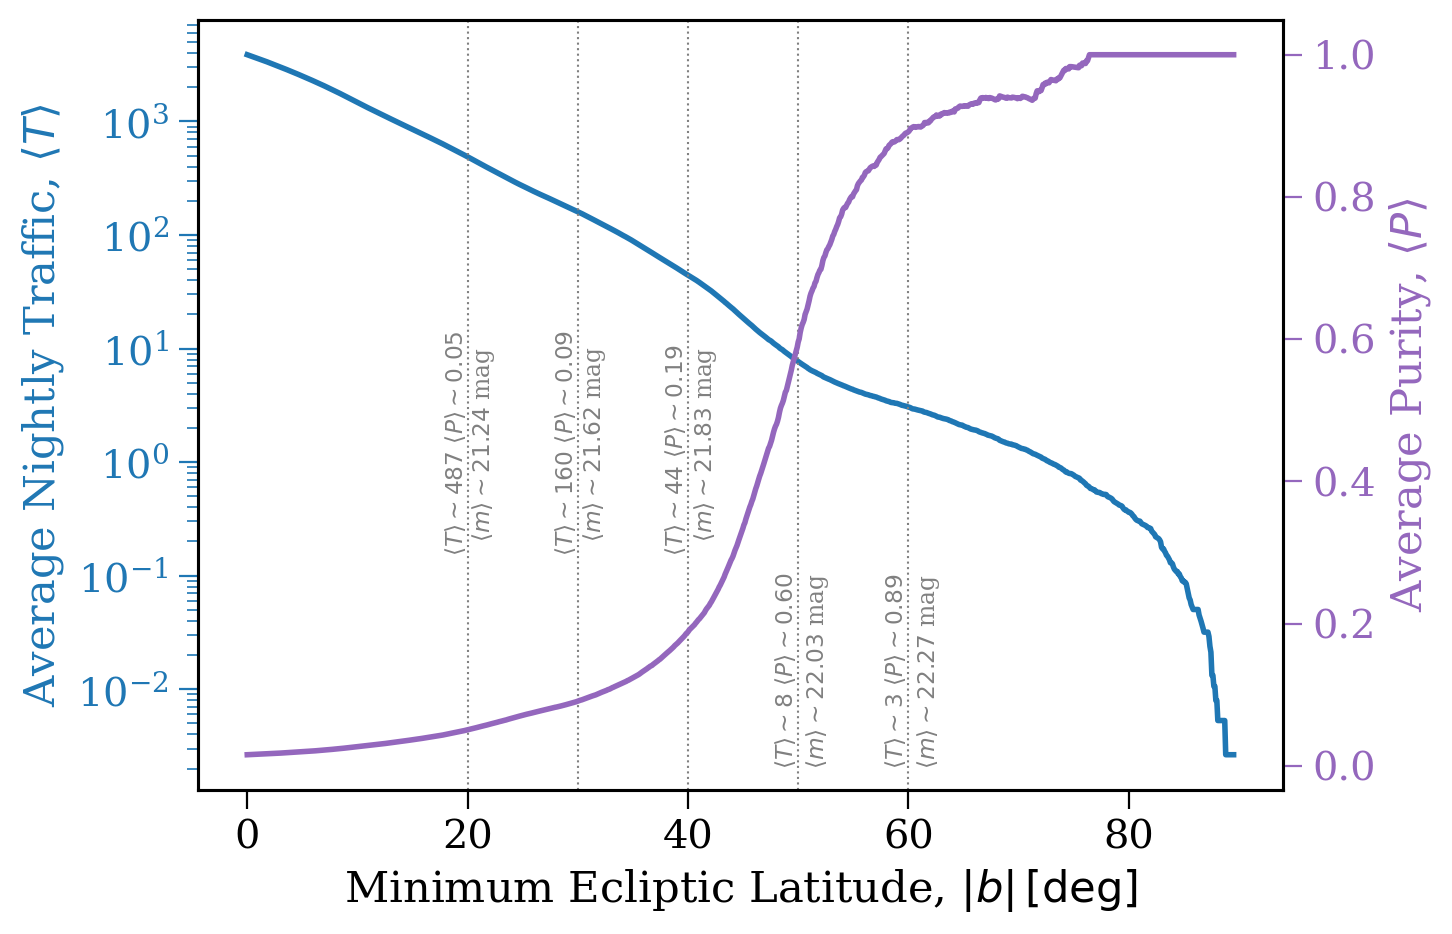

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))

left_col = "tab:blue"
right_col = "tab:purple"

ax.plot(cutoffs, first_year_traffic / 377, lw=2)
ax.set_yscale("log")
ax.set_ylabel(r"Average Nightly Traffic, $\langle T \rangle$", fontsize=0.65*fs, color=left_col)

ax_right = ax.twinx()
ax_right.plot(cutoffs, first_year_purity, color=right_col, lw=2)
ax_right.set_ylabel(r"Average Purity, $\langle P \rangle$", fontsize=0.65*fs, color=right_col)
ax.set_xlabel(r"Minimum Ecliptic Latitude, $|b| \, {\rm [deg]}$", fontsize=0.65*fs)

ax.tick_params(axis="y", which="both", colors=left_col)
ax_right.tick_params(axis="y", which="both", colors=right_col)

for lim in range(20, 60 + 10, 10):
    t, p, am = first_year_stats(neo_obs_dd_neocp, mba_obs_dd_neocp, lim)
    ax.axvline(lim, color="grey", linestyle="dotted", lw=0.75)
    y_val = 2e-3 if lim >= 50 else 1.5e-1
    y_val2 = 2e-3 if lim >= 50 else 2e-1
    ax.annotate(rf"$\langle T \rangle{{\sim}}{{{t / 377:1.0f}}}$ $\langle P \rangle{{\sim}}{{{p:1.2f}}}$",
                xy=(lim, y_val), rotation=90, ha="right", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    ax.annotate(rf"$\langle m \rangle{{\sim}}{{{am:1.2f}}}$ mag",
                xy=(lim * 1.01, y_val2), rotation=90, ha="left", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    
# plt.savefig("../paper/figures/ecliptic_latitude_cutoff.pdf", format="pdf", bbox_inches="tight")
plt.show()